#### STEP 0: Import Libraries and Functions

In [1]:
# Standard libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Going to make sure we can load all the custom scripts from the directory
scripts_dir = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\scripts\analysis"
# Add scripts directory to sys.path
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
from model_dependence import model_dependence
from analysis_functions import basin_loss_curve, interpolate_damages, get_copula_model, generate_conditional_sample
from analysis_functions import sectoral_monte_carlo_dependence_simulation, sectoral_urban_monte_carlo_dependence_simulation, run_DIGNAD
from analysis_functions import dignad_loss_probability, get_loss_for_rp, get_dignad_inputs_for_rp

#### STEP 1: Calibrate Copulas

In [2]:
clayton_copula_models, ordered_basins = model_dependence()

#### STEP 2: Load and clean risk data

In [3]:
risk_data_file = r"D:\projects\sovereign-risk\Thailand\analysis\flood\risk_analysis\dignad\urban\risk_basin_zonal_sum.csv"
risk_data = pd.read_csv(risk_data_file)
# Add columne for annual exceedance probability
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
# Add row for each combination that sums residential and non-residential damages
grouped = risk_data.groupby(['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'], as_index=False)['damages'].sum()
grouped['urban_class'] = 'Combined'  # Add a column for urban_class with value 'total'
risk_data = pd.concat([risk_data, grouped], ignore_index=True).sort_values(by=['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'])
risk_data.reset_index(drop=True, inplace=True)

#### STEP 3: Run the simulation

In [135]:
# Run the simulation
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000] # these are the RPs we are considering
n_simulations = 1000
n_years = 100
basin = 'HB_L6' # only looking at HydroBASIN level 6 basins
epoch ='Today'
scenario = 'Baseline'
res_df, com_df, ind_df, inf_df = sectoral_monte_carlo_dependence_simulation(risk_data, rps, basin, epoch, scenario, 0.5, n_years, ordered_basins, clayton_copula_models, n_simulations)

#### STEP 5: Extract DIGNAD compliant loss-probability curves

In [136]:
losses, tradable, nontradable, public, private, share_tradable = dignad_loss_probability(res_df, com_df, ind_df, inf_df, 0.911, 0, 0.7205,
                                                                                        0.3544, 0.885, 0.8503, 0.4208, 0, 14241662000000,
                                                                                        25778622000000, 17367000000000) 
# Calculate exceedance probabilities
num_losses = len(losses)
exceedance_probabilities = np.arange(num_losses, 0, -1) / num_losses

C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\scripts\analysis\analysis_functions.py:1238: RuntimeWarning: invalid value encountered in divide
  share_tradable = ((res_losses * res_share_tra) + (com_losses * com_share_tra) + (ind_losses * ind_share_tra) + (inf_losses * inf_share_tra)) / ((res_losses * res_share_pri) + (com_losses * com_share_pri) + (ind_losses * ind_share_pri) + (inf_losses * inf_share_pri))


#### STEP 5.5: Run Steps 4 and 5 in a loop

In [4]:
# Run the simulation
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000] # these are the RPs we are considering
n_simulations = 1000
n_years = 100
basin = 'HB_L6' # only looking at HydroBASIN level 6 basins
epochs =['Today', 'Future_High_Emission', 'Future_Low_Emission']
scenarios = ['Baseline', 'Urban_Protection_11', 'Urban_Protection_12', 'Urban_Protection_13', 'Urban_Protection_21',
             'Urban_Protection_22','Urban_Protection_23', 'Urban_Protection_30']
results_dic = {}
dignad_dic = {}
for epoch in epochs:
    scenario_dic = {}
    d_scenario_dic = {}
    for scenario in scenarios:
        if scenario == 'Baseline':
            res_df, com_df, ind_df, inf_df = sectoral_monte_carlo_dependence_simulation(risk_data, rps, basin, epoch, scenario, 0.5, n_years,
                                                                                        ordered_basins, clayton_copula_models, n_simulations)
        else:
            res_df, com_df, ind_df, inf_df = sectoral_urban_monte_carlo_dependence_simulation(risk_data, rps, basin, epoch, scenario, 0.5, n_years,
                                                                                               ordered_basins, clayton_copula_models, n_simulations)
        losses, tradable, nontradable, public, private, share_tradable = dignad_loss_probability(res_df, com_df, ind_df, inf_df, 0.911, 0, 0.7205,
                                                                                        0.3544, 0.885, 0.8503, 0.4208, 0, 14241662000000,
                                                                                        25778622000000, 17367000000000) 
        scenario_dic[scenario] = [res_df, com_df, ind_df, inf_df]
        d_scenario_dic[scenario] = [losses, tradable, nontradable, public, private, share_tradable]
    results_dic[epoch] = scenario_dic
    dignad_dic[epoch] = d_scenario_dic

C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\scripts\analysis\analysis_functions.py:1238: RuntimeWarning: invalid value encountered in divide
  share_tradable = ((res_losses * res_share_tra) + (com_losses * com_share_tra) + (ind_losses * ind_share_tra) + (inf_losses * inf_share_tra)) / ((res_losses * res_share_pri) + (com_losses * com_share_pri) + (ind_losses * ind_share_pri) + (inf_losses * inf_share_pri))
C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\scripts\analysis\analysis_functions.py:1238: RuntimeWarning: invalid value encountered in divide
  share_tradable = ((res_losses * res_share_tra) + (com_losses * com_share_tra) + (ind_losses * ind_share_tra) + (inf_losses * inf_share_tra)) / ((res_losses * res_share_pri) + (com_losses * com_share_pri) + (ind_losses * ind_share_pri) + (inf_losses * inf_share_pri))
C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\scripts\analysis\analysis_functions.py:1238: RuntimeWarning: invalid value encountered in divi

In [7]:
# Save these to temp file
import pickle
dig_file = r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\Sovereign-Risk\Presentations\data\29-May\dig_file.pkl"
res_file = r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\Sovereign-Risk\Presentations\data\29-May\res_file.pkl"
with open (dig_file, 'wb') as f:
    pickle.dump(dignad_dic, f)
with open (res_file, 'wb') as f:
    pickle.dump(results_dic, f)

#### STEP 5.7 Cost-Benefit Analysis

In [59]:
adaptation_costs = {'Urban_Protection_11': 190260000000,
                    'Urban_Protection_12': 189940000000,
                    'Urban_Protection_13': 94460000000,
                    'Urban_Protection_21': 52650000000,
                    'Urban_Protection_22': 36230000000,
                    'Urban_Protection_23': 21970000000,
                    'Urban_Protection_30': 6810000000}
thb_usd_xr = 0.028
discount_rate = 0.08
o_and_m_costs = 0.01 # operation and maintenance
years_to_construct = 30
years_effective = 78
epoch = 'Future_High_Emission'
# Total losses
baseline = dignad_dic[epoch]['Baseline'][0] * thb_usd_xr
baseline_aal = np.mean(baseline)

for key in adaptation_costs:
    adaptation = dignad_dic[epoch][key][0] * thb_usd_xr
    adaptation_aal = np.mean(adaptation)
    diff_aal = baseline_aal - adaptation_aal
    benefits = 0
    costs = 0
    for i in range(1, years_effective+1):
        if i <= years_to_construct:
            benefit = ((diff_aal/30)*i)/((1+discount_rate)**i)
            cost = (adaptation_costs[key]*o_and_m_costs)/((1+discount_rate)**i) + (adaptation_costs[key]/years_to_construct)
        else:
            benefit = diff_aal/((1+discount_rate)**i)
            cost = (adaptation_costs[key]*o_and_m_costs)/((1+discount_rate)**i)
        benefits += benefit
        costs += cost
    print('Adaptation Scenario: %s' % key)
    print('Costs: %s b USD'  % (costs/1000000000))
    print('Benefits: %s b USD' % (benefits//1000000000))
    print('BCR: %s' % (benefits/costs))

Adaptation Scenario: Urban_Protection_11
Costs: 213.9837233841332 b USD
Benefits: 55.0 b USD
BCR: 0.26024059835359376
Adaptation Scenario: Urban_Protection_12
Costs: 213.6238222410506 b USD
Benefits: 55.0 b USD
BCR: 0.26136068040267724
Adaptation Scenario: Urban_Protection_13
Costs: 106.23831867373714 b USD
Benefits: 49.0 b USD
BCR: 0.4696594799475994
Adaptation Scenario: Urban_Protection_21
Costs: 59.21498494783252 b USD
Benefits: 47.0 b USD
BCR: 0.8046916637564556
Adaptation Scenario: Urban_Protection_22
Costs: 40.74755754339931 b USD
Benefits: 39.0 b USD
BCR: 0.972123213725334
Adaptation Scenario: Urban_Protection_23
Costs: 24.709462854774564 b USD
Benefits: 37.0 b USD
BCR: 1.5344160920099315
Adaptation Scenario: Urban_Protection_30
Costs: 7.659146201229621 b USD
Benefits: 30.0 b USD
BCR: 4.038809640819716


#### STEP 6: Run DIGNAD

In [82]:
# User inpnuts ######
calibration_csv = r"D:\projects\sovereign-risk\Thailand\data\DIGNAD\inputs\THA_2022_calibration.csv"
rp = 100
nat_disaster_year = 2022
recovery_period = 5 # years
reconstruction_efficiency = 0
public_debt_premium = 0
#####################
# Extract data from loss-probability curve
tradable_impact, nontradable_impact, public_impact, private_impact, share_tradable_impact = get_dignad_inputs_for_rp(rp, exceedance_probabilities,
                                                                                                                    tradable, nontradable, public,
                                                                                                                    private, share_tradable)
# Run DIGNAD
gdp_impact, years = run_DIGNAD(calibration_csv, nat_disaster_year, recovery_period, tradable_impact, nontradable_impact, reconstruction_efficiency,
                                public_debt_premium, public_impact, private_impact, share_tradable_impact)

#### STEP 7: Sovereign Ratings

In [70]:
# Going to linearly interpolate in the first instance (based on values for Thailand from Matt)
def sovereign_ratings(gdp_impact, max=True):
    '''
    function to return sovereign ratings impact. 
    takes as input the gdp_impact (assuming flood impact in 2022)
    returns rating change, probability of default, and cost of debt
    for max (returns max GDP loss), else returns 5 year average (after event). 
    '''
    # Values from Matt
    GDP_loss = [0, 4, 14]
    rating_change = [0, 1.8, 8]
    probability_of_default = [3.1, 4.8, 46]
    cost_of_debt = [1.1, 1.5, 5.7]

    # Convert to positive
    gdp_impact = [i*-1 for i in gdp_impact]

    if max:
        gdp = np.max(gdp_impact)
    else:
        gdp = np.mean(gdp_impact[1:6])
    
    rating = np.interp(gdp, GDP_loss, rating_change)
    PoD = np.interp(gdp, GDP_loss, probability_of_default)
    CoD = np.interp(gdp, GDP_loss, cost_of_debt)

    return gdp, rating, PoD, CoD

#### 7.5 Run this all in a loop

In [86]:
# User inputs
# DIGNAD inputs
calibration_csv = r"D:\projects\sovereign-risk\Thailand\data\DIGNAD\inputs\THA_2022_calibration.csv"
nat_disaster_year = 2022
recovery_period = 5 # years
reconstruction_efficiency = 0
public_debt_premium = 0
# What RPs to consider?
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000, 5000, 10000]
# Write exceedance probabilities
num_years = 100000
exceedance_probabilities = np.arange(num_years, 0, -1) / num_years

# Run it
sovereign_dic = {}
for i in dignad_dic:
    scenario_dic = {} 
    for j in dignad_dic[i]:
        rp_dic = {}
        for rp in rps:
            # Debug
            print('Working on rp %s for scenario %s and epoch %s' % (rp, j, i))
            tradable_impact, nontradable_impact, public_impact, private_impact, share_tradable_impact = get_dignad_inputs_for_rp(rp, exceedance_probabilities,
                                                                                                                    dignad_dic[i][j][1], dignad_dic[i][j][2],
                                                                                                                    dignad_dic[i][j][3], dignad_dic[i][j][4],
                                                                                                                    dignad_dic[i][j][5])
            print(tradable_impact, nontradable_impact, public_impact, private_iimpact, share_tradable_impact)
            gdp_impact, years = run_DIGNAD(calibration_csv, nat_disaster_year, recovery_period, tradable_impact, nontradable_impact,
                                           reconstruction_efficiency, public_debt_premium, public_impact, private_impact, share_tradable_impact)
            # # Debug
            # if gdp_impact == None:
            #     continue
            
            gdp, rating, PoD, CoD = sovereign_ratings(gdp_impact, max=False)
            
            print(gdp, rating, PoD, CoD)
            
            rp_dic[rp] = [gdp, rating, PoD, CoD]
        scenario_dic[j] = rp_dic
    sovereign_dic[i] = scenario_dic
    

Working on rp 2 for scenario Baseline and epoch Today


NameError: name 'private_iimpact' is not defined

In [75]:
# Save these to temp file
import pickle
sov_file = r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\Sovereign-Risk\Presentations\data\29-May\sov_file.pkl"
with open (sov_file, 'wb') as f:
    pickle.dump(sovereign_dic, f)

{'Today': {'Baseline': {2: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   5: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   10: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   25: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   50: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   100: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   200: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   500: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   1000: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   5000: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   10000: [-0.0006574123553917844, 0.0, 3.1, 1.1]},
  'Urban_Protection_11': {2: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   5: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   10: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   25: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   50: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   100: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   200: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   500: [-0.0006574123553917844, 0.0, 3.1, 1.1],
   1000: [-0.0006574123553917844, 

In [132]:
# Cost-Benefit-Analysis (including second order effects)
def pull_cod(epoch, scenario, rps, df):
    cod = []
    for i in rps:
        # adjust for actual cost of debt
         cod.append((df[epoch][scenario][i][3] - 1.1))
    return cod 
adaptation_costs = {'Urban_Protection_RP100': 52000000000}
thb_usd_xr = 0.028
discount_rate = 0.05
o_and_m_costs = 0.01 # operation and maintenance
years_to_construct = 30
years_effective = 78
epoch = 'Today'
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
aeps = [1/i for i in rps]
# Total losses
baseline = dignad_dic[epoch]['Baseline'][0] * thb_usd_xr
baseline_aal = np.mean(baseline)
# Second order losses
thailand_debt_usd = 302194000000
cod = pull_cod(epoch, 'Baseline', rps, sovereign_dic)
cod = [i*0.01*thailand_debt_usd for i in cod]
so_baseline_aal = np.trapz(aeps, cod)

print(baseline_aal/billion)
print(so_baseline_aal/billion)

for key in adaptation_costs:
    adaptation = dignad_dic[epoch][key][0] * thb_usd_xr
    adaptation_aal = np.mean(adaptation)
    adaptation_cod = pull_cod(epoch, key, rps, sovereign_dic)
    adaptation_cod = [i*0.01*thailand_debt_usd for i in adaptation_cod]
    so_adaptation_aal = np.trapz(aeps, adaptation_cod)
    diff_aal = baseline_aal - adaptation_aal
    so_diff_aal = so_baseline_aal - so_adaptation_aal
    benefits = 0
    costs = 0
    benefits_so = 0
    for i in range(1, years_effective+1):
        if i <= years_to_construct:
            benefit = ((diff_aal/30)*i)/((1+discount_rate)**i)
            benefit_so = ((so_diff_aal/30)*i)/((1+discount_rate)**i)
            cost = (adaptation_costs[key]*o_and_m_costs)/((1+discount_rate)**i) + (adaptation_costs[key]/years_to_construct)
        else:
            benefit = diff_aal/((1+discount_rate)**i)
            benefit_so = so_diff_aal/((1+discount_rate)**i)
            cost = (adaptation_costs[key]*o_and_m_costs)/((1+discount_rate)**i)
        benefits += benefit
        costs += cost
        benefits_so += benefit + benefit_so
    print('Adaptation Scenario: %s' % key)
    print('Costs: %s b USD'  % (costs/1000000000))
    print('Benefits: %s b USD' % (benefits//1000000000))
    print('Benefits (including SO): %s b USD' % (benefits_so//1000000000))
    print('BCR: %s' % (benefits/costs))
    print('BCR (including SO): %s' % (benefits_so/costs))

8.941682590320081
0.11758453240015147
Adaptation Scenario: Urban_Protection_RP100
Costs: 62.168650794787474 b USD
Benefits: 66.0 b USD
Benefits (including SO): 67.0 b USD
BCR: 1.0687239024223358
BCR (including SO): 1.0834387335781297


#### RESULTS

##### Stats

In [36]:
thb_usd_xr = 0.028
billion = 1000000000
thb_aal = np.mean(losses)
usd_aal_b = thb_aal * thb_usd_xr / billion
rp_thb = get_loss_for_rp(rp, losses, exceedance_probabilities)
rp_usd_b = get_loss_for_rp(rp, losses, exceedance_probabilities) * thb_usd_xr / billion
max_gdp = np.min(gdp_impact)
avg_gdp = np.mean(gdp_impact[1:5]) # just take average GDP impact following 
print('Losses in Thai Baht. AAL: %s, %s-year: %s' % (thb_aal, rp, rp_thb))
print('Losses in billion USD. AAL: %s, %s-year: %s' % (usd_aal_b, rp, rp_usd_b))
print('%s-year GDP loss: max: %s, 5-year: %s' % (rp, max_gdp, avg_gdp))

Losses in Thai Baht. AAL: 318689824542.6516, 97-year: 2638256037467.589
Losses in billion USD. AAL: 8.923315087194245, 97-year: 73.87116904909249
97-year GDP loss: max: -5.636733805217631, 5-year: -3.4345318158539917


##### Plots

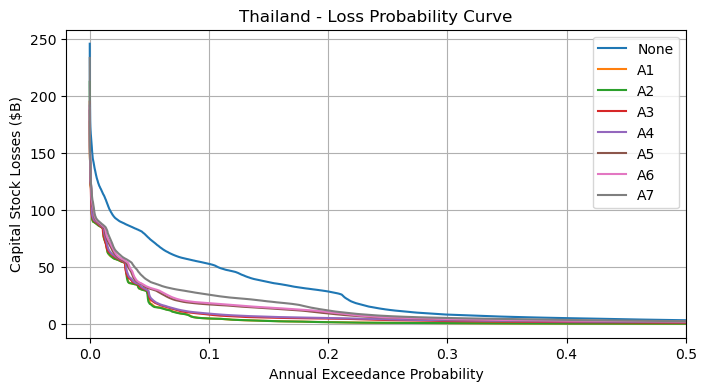

In [26]:
# Loss Probability Curve
thb_usd_xr = 0.028
billion = 1000000000
num_years = 100000
exceedance_probabilities = np.arange(num_years, 0, -1) / num_years
# Step 3: Plot the loss probability graph
plt.figure(figsize=(8, 4))
plt.plot(exceedance_probabilities, (dignad_dic['Future_High_Emission']['Baseline'][0]*thb_usd_xr)/billion, linestyle='-', label='None')
plt.plot(exceedance_probabilities, (dignad_dic['Future_High_Emission']['Urban_Protection_11'][0]*thb_usd_xr)/billion, linestyle='-', label='A1')
plt.plot(exceedance_probabilities, (dignad_dic['Future_High_Emission']['Urban_Protection_12'][0]*thb_usd_xr)/billion, linestyle='-', label='A2')
plt.plot(exceedance_probabilities, (dignad_dic['Future_High_Emission']['Urban_Protection_13'][0]*thb_usd_xr)/billion, linestyle='-', label='A3')
plt.plot(exceedance_probabilities, (dignad_dic['Future_High_Emission']['Urban_Protection_21'][0]*thb_usd_xr)/billion, linestyle='-', label='A4')
plt.plot(exceedance_probabilities, (dignad_dic['Future_High_Emission']['Urban_Protection_22'][0]*thb_usd_xr)/billion, linestyle='-', label='A5')
plt.plot(exceedance_probabilities, (dignad_dic['Future_High_Emission']['Urban_Protection_23'][0]*thb_usd_xr)/billion, linestyle='-', label='A6')
plt.plot(exceedance_probabilities, (dignad_dic['Future_High_Emission']['Urban_Protection_30'][0]*thb_usd_xr)/billion, linestyle='-', label='A7')

# plt.axhline(thb_aal)
plt.ylabel('Capital Stock Losses ($B)')
plt.xlabel('Annual Exceedance Probability')
plt.title('Thailand - Loss Probability Curve')
plt.legend()
plt.xlim(left = -0.02, right = 0.5)  # adjust the right leaving left unchanged
plt.grid(True)
# plt.yscale('log')  # Optionally use a logarithmic scale for the y-axis
plt.show()

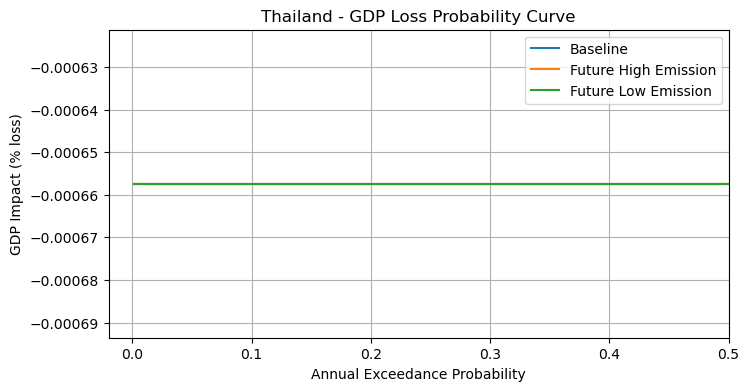

In [74]:
# GDP Probability Curve
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
aeps = [1/i for i in rps]
def pull_gdps(epoch, scenario, rps, df):
    gdp_losses = []
    for i in rps:
         gdp_losses.append(df[epoch][scenario][i][0])
    return gdp_losses
        
plt.figure(figsize=(8, 4))
plt.plot(aeps, pull_gdps('Today', 'Baseline', rps, sovereign_dic), linestyle='-', label='Baseline')
plt.plot(aeps, pull_gdps('Future_High_Emission', 'Baseline', rps, sovereign_dic), linestyle='-', label='Future High Emission')
plt.plot(aeps, pull_gdps('Future_Low_Emission', 'Baseline', rps, sovereign_dic), linestyle='-', label='Future Low Emission')
# plt.axhline(thb_aal)
plt.ylabel('GDP Impact (% loss)')
plt.xlabel('Annual Exceedance Probability')
plt.title('Thailand - GDP Loss Probability Curve')
plt.legend()
plt.xlim(left = -0.02, right = 0.5)  # adjust the right leaving left unchanged
plt.grid(True)
# plt.yscale('log')  # Optionally use a logarithmic scale for the y-axis
plt.show()

In [73]:
# More STATS
rp = 10
epoch = 'Future_High_Emission'
scenario = 'Baseline'
print('%s loss:' % rp, get_loss_for_rp(rp, (dignad_dic[epoch][scenario][0]*thb_usd_xr)/billion, exceedance_probabilities))
print('%s GDP loss:' % rp ,sovereign_dic[epoch][scenario][rp][0])
print('AAL:', np.mean(dignad_dic[epoch][scenario][0])*thb_usd_xr/billion)
print('GDP AAL:', np.trapz(aeps, pull_gdps(epoch, scenario, rps, sovereign_dic)))
print('%s downgrade:' % rp, sovereign_dic[epoch][scenario][rp][1])
print('%s PoD:' % rp, sovereign_dic[epoch][scenario][rp][2] - 3.1)
print('%s CoD:' % rp, (sovereign_dic[epoch][scenario][rp][3] - 1.1)*301.7/100)

10 loss: 52.60853019843872
10 GDP loss: -0.0006574123553917844
AAL: 14.756855882597202


NameError: name 'aeps' is not defined

-5.697006826593654
-0.8385042041216109
-3.4893568580355914
[-5.697006826593654, -4.094002878732594, -2.549154360047823, -1.6172633667682956, -1.045486526079642]


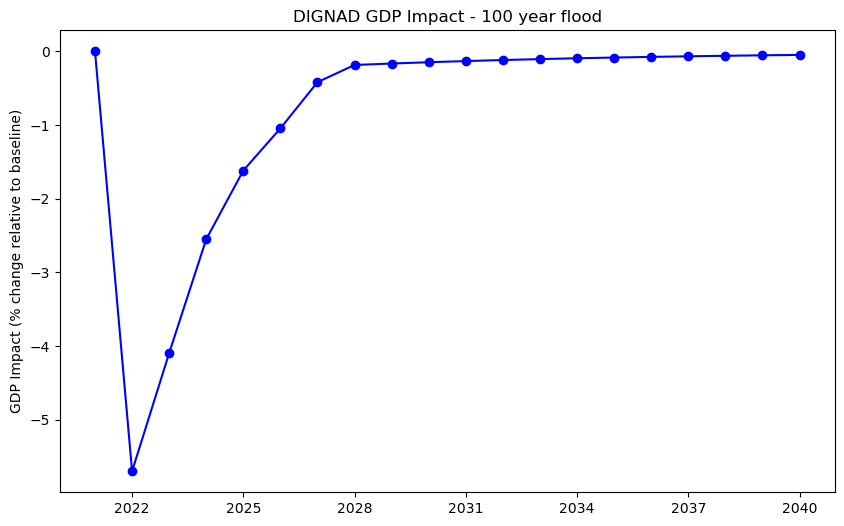

In [50]:
# Plot DIGNAD
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10,6))
plt.plot(years, gdp_impact, marker='o', linestyle='-', color='b', label='GDP losses')
plt.title('DIGNAD GDP Impact - 100 year flood')
plt.ylabel('GDP Impact (% change relative to baseline)')
# plt.axvline(2022, color='r')
# Ensure x-axis shows whole numbers and every year
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
print(np.min(gdp_impact))
print(np.mean(gdp_impact))
print(np.mean(gdp_impact[1:5]))
print(gdp_impact[1:6])

In [ ]:
### EXTRA: SENSITIVITY ANALYSIS
# What parameter are we going to assess sensitvity of?
reconstruction_efficiencies = np.linspace(0, 0.5, 10)
public_debt_premiums = np.linspace(0, 0.5, 10)
# Calculate exceedance probabilities
num_losses = len(losses)
exceedance_probabilities = np.arange(num_losses, 0, -1) / num_losses
# User inpnuts ######
calibration_csv = r"D:\projects\sovereign-risk\Thailand\data\DIGNAD\inputs\THA_2010_calibration.csv"
rp = 100
nat_disaster_year = 2022
recovery_period = 5 # years
#reconstruction_efficiency = 0
#public_debt_premium = 0
#####################
# Run sensitivity analysis
results = []
for reconstruction_efficiency in reconstruction_efficiencies:
    for public_debt_premium in public_debt_premiums:
        gdp_impact, years = run_DIGNAD(calibration_csv, nat_disaster_year, recovery_period, tradable_impact, nontradable_impact, reconstruction_efficiency,
                                    public_debt_premium, public_impact, private_impact, share_tradable_impact)
        avg_gdp_impact = np.mean(gdp_impact)
        max_gdp_impact = np.min(gdp_impact)
        results.append({
            'Reconstruction Efficiency': reconstruction_efficiency,
            'Public Debt Premium': public_debt_premium,
            'Avg GDP Impact': avg_gdp_impact,
            'Max GDP Impact': max_gdp_impact
        })
results_df = pd.DataFrame(results)

In [ ]:
results_df

In [ ]:
# Plot sensitivity
fig, ax = plt.subplots(figsize=(12, 8))

# Pivot the DataFrame to a suitable format for heatmap plotting
pivot_table = results_df.pivot_table(values='Max GDP Impact', index='Public Debt Premium', columns='Reconstruction Efficiency')

cax = ax.matshow(pivot_table, cmap='viridis')
fig.colorbar(cax)

# Set axis labels
ax.set_xlabel('Reconstruction Efficiency')
ax.set_ylabel('Public Debt Premium')

# Set ticks based on the pivot table shape
ax.set_xticks(np.arange(len(pivot_table.columns)))
ax.set_yticks(np.arange(len(pivot_table.index)))

# Set tick labels based on the actual unique values used in the pivot table
ax.set_xticklabels([f"{eff:.2f}" for eff in pivot_table.columns])
ax.set_yticklabels([f"{debt:.2f}" for debt in pivot_table.index])

# Move x tick labels to the bottom
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')

plt.title('Sensitivity Analysis of GDP Impact')
plt.show()